In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Define Kalman Filter Function

In [2]:
def kalman_filter(
    y,
    A,
    H,
    P0,
    x0,
    cov_transition,
    cov_observation
):
    # Kalman Filter quantities initialization
    P_pri = P0
    P_post = np.array([])
    x_pri = x0
    x_post = np.array([])
    
    # Shapes
    n_states = len(x0)
    n_obs = y.shape[0]
    
    # Kalman filter loop
    results = pd.DataFrame()
    for k in range(y.shape[-1]):
        
        # Get Kalman gain from a priori estimations
        Q = P_pri@np.transpose(H)@np.linalg.inv(H@P_pri@np.transpose(H) + cov_observation)
        
        # Get a posteriori estimation for x
        x_post = x_pri + Q@(y[:,k] - H@x_pri)
        
        # Get a posteriori error covariance matrix
        P_post = (np.eye(n_states) + Q@H)@P_pri
        
        # Log results for iteration
        results = pd.concat(
            [
                
                results,
                pd.DataFrame(
                    index=[k],
                    data={
                        'iteration': [k+1],
                        'x_prior': [x_pri],
                        'x_posterior': [x_post],
                        'kalman_gain': [Q],
                        'P_prior': [P_pri],
                        'P_posterior': [P_post]
                    }
                )
            ],
            axis=0
        )
        
        # Get a priori state estimate for next iteration
        x_pri = A@x_post
        
        # Get a priori error cov estimate for next iteration
        P_pri = A@P_post@np.transpose(A) + cov_transition
        
    return results

# 2. Create arrays and execute filter

In [3]:
N_ITERS = 500
STATE_NOISE_STD = 1.0
MEAS_NOISE_STD = 1.0
TRANSITION_DAMPING = 0.4

# Transition matrix
A = np.array([
    [1, -TRANSITION_DAMPING],
    [TRANSITION_DAMPING, TRANSITION_DAMPING]
])

# State noise covariance matrix
state_noise_cov = np.eye(2)*np.square(STATE_NOISE_STD)

# Generate AR(1) states
x_true = [np.random.normal(0, STATE_NOISE_STD, (2,))]
for i, w in enumerate(
    np.random.normal(
        0,
        STATE_NOISE_STD,
        (N_ITERS-1, 2)
    )
):
    x_true.append(
        list(A@np.transpose(x_true[i]) + w.T)
    )

x_true = np.array(x_true).T
    
# Measurement matrix: y will be the difference and sum of AR(1) processes
H = np.array([
    [2, 1],
    [1, 2]
])
H = np.array([
    [1, 0]
])

# Measurement covariance matrix
meas_noise_cov = np.eye(1)*np.square(MEAS_NOISE_STD)

# Generate observed y
y_true = H@x_true + np.random.normal(0, MEAS_NOISE_STD)

In [4]:
# Execute Kalman Filter
res = kalman_filter(
    y=y_true,
    A=A,
    H=H,
    P0=np.eye(2),
    x0=np.array([0, 0]).T,
    cov_transition=state_noise_cov,
    cov_observation=meas_noise_cov
)
res

,iteration,x_prior,x_posterior,kalman_gain,P_prior,P_posterior
0,1,"[0, 0]","[1.011328316457927, 0.0]","[[0.5], [0.0]]","[[1.0, 0.0], [0.0, 1.0]]","[[1.5, 0.0], [0.0, 1.0]]"
1,2,"[1.011328316457927, 0.4045313265831708]","[3.3454983528969695, 0.7906346408813585]","[[0.7267759562841529], [0.12021857923497269]]","[[2.66, 0.44000000000000006], [0.4400000000000...","[[4.593224043715847, 0.7597814207650274], [0.7..."
2,3,"[3.0292444965444263, 1.6544531975113312]","[4.055672222936751, 2.0060156968978897]","[[0.8391730224082073], [0.2874257559395248]]","[[5.217862295081968, 1.7871737704918036], [1.7...","[[9.596551567755728, 3.2869217850440826], [3.2..."
3,4,"[3.2532659441775955, 2.4246751679338567]","[2.0803867988941533, 1.8396077542369036]","[[0.893649654875199], [0.44577934089079146]]","[[8.402884389575885, 4.1916116056574495], [4.1...","[[15.91211912427657, 7.937443870424107], [7.93..."
4,5,"[1.3445436971993918, 1.5679978212524228]","[0.8766031559858285, 1.2699770384412123]","[[0.920030905181745], [0.5859469450150367]]","[[11.504830800857382, 7.3271674056923155], [7....","[[22.08963069653302, 14.068387866369594], [14...."
...,...,...,...,...,...,...
495,496,"[-1.5480579108889803, -2.3914709569404597]","[-2.4411863212012426, -3.3670739258855362]","[[0.9084004337550456], [0.9922852637198772]]","[[9.917082263531823, 6.388809877470308], [10.8...","[[18.9257640933086, 12.192407541342856], [20.6..."
496,497,"[-1.094356750847028, -2.323304098834712]","[-0.9132420563029036, -2.1216825466340072]","[[0.9072395839111838], [1.0099625189800943]]","[[9.780460482653725, 6.1384859603907485], [10....","[[18.653681381396265, 11.707563408940294], [20..."
497,498,"[-0.06456903764930066, -1.2139698411747644]","[0.1333337697612845, -0.9890364202827076]","[[0.905858652795245], [1.0295856248020365]]","[[9.622325149278211, 5.864003447499937], [10.9...","[[18.338791645761177, 11.175961710438902], [20..."
498,499,"[0.5289483378743676, -0.34228106020856924]","[-0.1494038354584819, -1.1311336731204846]","[[0.9042062330103479], [1.0514972569734258]]","[[9.439092557118283, 5.56279922808611], [10.97...","[[17.973978881226216, 10.592716963106723], [20..."


# 3. Show results: estimated vs true states

In [5]:
def proc_results(
    x_true,
    results
):
    res_proc = pd.DataFrame()
    # Get true and estimated (prior, posterior) states in iterations
    for i, row in results.iterrows():
        res_proc = pd.concat(
            [
                res_proc,
                pd.DataFrame(
                    index=[i],
                    data={
                        'iteration': [row['iteration']],
                        'x1_true': x_true[:, i][0],
                        'x2_true': x_true[:, i][1],
                        'x1_prior': [row['x_prior'][0]],
                        'x2_prior': [row['x_prior'][1]],
                        'x1_posterior': [row['x_posterior'][0]],
                        'x2_posterior': [row['x_posterior'][1]],
                    }
                )
            ]
        )
        
    # Plot estimations
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20,10)
    )
    
    # X1
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_true'].values,
        label='true'
    )
    ax1.scatter(
        res_proc['iteration'].values,
        res_proc['x1_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_posterior'].values,
        linestyle='--',
        marker='x',
        label='posterior'
    )
    ax1.legend()
    ax1.set_title('x1')
    
    # X2
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_true'].values,
        label='true'
    )
    ax2.scatter(
        res_proc['iteration'].values,
        res_proc['x2_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_posterior'].values,
        marker='x',
        linestyle='--',
        label='posterior'
    )
    ax2.legend()
    ax2.set_title('x2')
        
    return res_proc

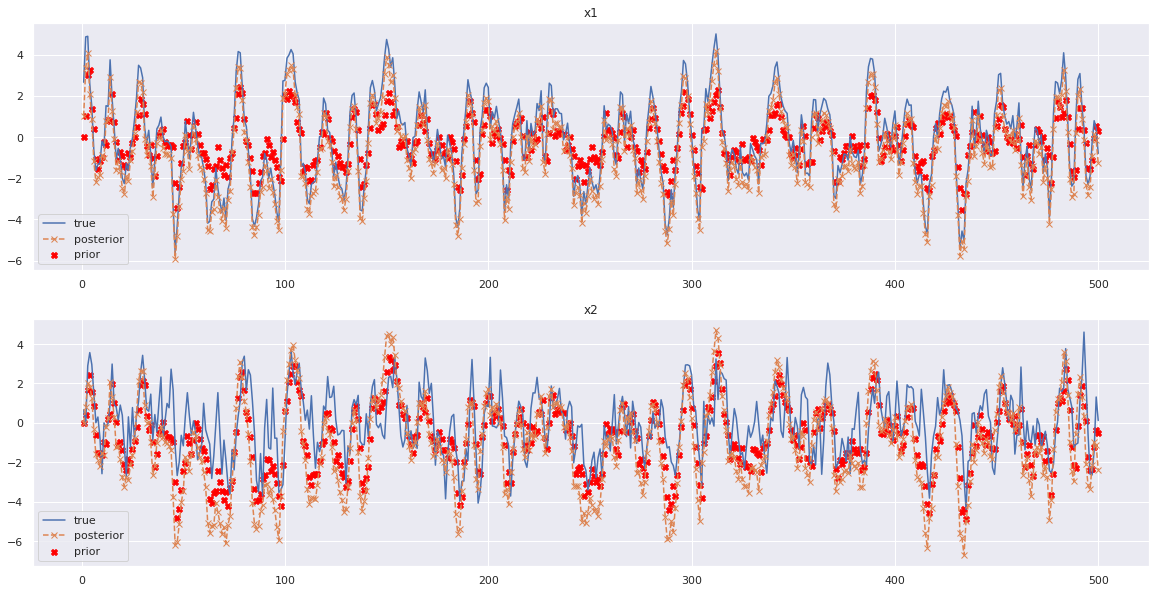

In [6]:
proc_results = proc_results(
    x_true=x_true,
    results=res
)